# Probar la extracción de datos y análisis para la API de BingX

In [1]:
import os
import requests
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

interval | field description
---------|-----------------
1m | One-minute K line
3m | Three-minute K line
5m | Five-minute K line
15m | 15 minutes K line
30m | Thirty minutes K line
1h | One-hour candlestick line
2h | Two-hour K-line
4h | Four-hour K line
6h | Six-hour K line
8h | Eight-hour K-line
12h | 12-hour K line
1d | 1 day candlestick
3d | 3-day K-line
1w | Weekly K-line
1M | Monthly candlestick

# 1) Data Minning

In [2]:
def past_timestamp(cantidad, periodo):
    "Devuelve en milisegundos el timestamp de hace 'cantidad' 'periodo'"
    if periodo == "min":
        delta = datetime.timedelta(minutes=cantidad)
    elif periodo == "hour":
        delta = datetime.timedelta(hours=cantidad)
    elif periodo == "days":
        delta = datetime.timedelta(days=cantidad)
    else:
        raise ValueError("Período inválido")
    
    now = datetime.datetime.now()
    past = now - delta
    timestamp = datetime.datetime.timestamp(past)
    return timestamp * 1000

def now_timestamp():
    "devuelve en milisegundos el timestamp actual"
    return datetime.datetime.timestamp(datetime.datetime.now()) * 1000

def response_to_dataframe(response):
    data = response['data']
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df[['open', 'close', 'high', 'low', 'volume']] = df[['open', 'close', 'high', 'low', 'volume']].astype(float)
    return df

def guardar_csv(path_output, data):
    """
    Guarda un DataFrame como archivo CSV en la ruta especificada.

    Argumentos:
    - path_output: ruta relativa o absoluta donde se guardará el archivo CSV.
    - data: DataFrame a guardar como archivo CSV.

    """
    # Obtener el path absoluto del archivo de salida
    path_absoluto_output = os.path.abspath(path_output)
    print('Guardando en ubicación:')
    print(path_absoluto_output)
    # Abrir el archivo de salida
    with open(path_absoluto_output, 'w') as archivo_output:
        # Guardar el archivo csv
        data.to_csv(archivo_output, index=False)

def crear_directorio(path_output):
    """
    Crea un directorio en la ruta especificada si este no existe. Si el directorio ya existe, se muestra un mensaje indicando
    la ubicación del directorio existente.

    Argumentos:
    - path_output: ruta relativa o absoluta donde se creará el directorio.

    """
    path_absoluto_output = os.path.abspath(path_output)
    if not os.path.exists(path_absoluto_output):
        print(f'Se crea el directorio {path_output} en ubicación:')
        print(path_absoluto_output)
        os.makedirs(path_absoluto_output)
    else:
        print(f'Directorio {path_absoluto_output} ya existe')


In [3]:
URL = 'https://open-api.bingx.com'
path = '/openApi/swap/v2/quote/klines'
method = 'GET'

service = URL + path

symbol = 'BTC-USDT'
interval = '15m'
limit = 1440  #default 500, max 1440

startTime = int(past_timestamp(1400*15, 'min'))
endTime = int(now_timestamp())

if False:
    response = requests.request(method, service, params={'symbol':symbol, 'interval':interval, 'limit':limit, 'startTime':startTime, 'endTime':endTime})
    df = response_to_dataframe(response.json())
    fecha_actual = datetime.datetime.now()
    crear_directorio('data')
    nombre_archivo = "{}_{}_{}.csv".format(symbol, interval, fecha_actual.strftime('%Y-%m-%d_%H-%M-%S'))
    guardar_csv('data/{}'.format(nombre_archivo), df)
    with open('last_file.txt', 'w') as f:
        f.write(nombre_archivo)


else:
    with open('last_file.txt', 'r') as f:
        nombre_archivo = f.read()
    df = pd.read_csv('data/{}'.format(nombre_archivo))


In [4]:
df

,open,close,high,low,volume,time
0,30388.5,30386.0,30400.0,30372.0,124.22,2023-04-15 02:15:00
1,30386.0,30386.2,30399.5,30344.5,183.56,2023-04-15 02:30:00
2,30386.2,30378.0,30406.5,30378.0,100.04,2023-04-15 02:45:00
3,30378.0,30389.0,30420.5,30375.5,166.78,2023-04-15 03:00:00
4,30389.0,30386.0,30405.0,30382.5,124.14,2023-04-15 03:15:00
...,...,...,...,...,...,...
1394,29346.0,29331.5,29351.0,29321.0,158.80,2023-04-29 14:45:00
1395,29331.5,29308.0,29332.0,29308.0,148.35,2023-04-29 15:00:00
1396,29308.5,29330.0,29338.0,29308.0,135.06,2023-04-29 15:15:00
1397,29330.0,29332.0,29333.0,29314.5,140.54,2023-04-29 15:30:00


In [5]:
df_1 = df.copy()

# 2) 1er Feature: cruce EMAS + RSI 

Tener cuidado con el Look-Ahead Bias, para eso atrasamos todos los datos un registro, excepto variacion

In [6]:
# cruce de SMAs
def cruce_sma_fast_slow(data, fast, slow):
    dataux = pd.DataFrame()
    dataux[f"SMA_{fast}"] = data.loc[:, "close"].rolling(fast).mean()
    dataux[f"SMA_{slow}"] = data.loc[:, "close"].rolling(slow).mean()
    data.loc[:, f"Cruce_{fast}_{slow}"] = (
        dataux.loc[:, f"SMA_{fast}"] / dataux.loc[:, f"SMA_{slow}"] * 100 - 100
    )
    return data

# calculo rsi
def rsi(data, ruedas):
    dataux = pd.DataFrame()
    dataux["dif"] = data['close'].diff()
    dataux["win"] = np.where(dataux["dif"] > 0, dataux["dif"], 0)
    dataux["loss"] = np.where(dataux["dif"] < 0, abs(dataux["dif"]), 0)
    dataux["ema_win"] = dataux.win.ewm(alpha=1 / ruedas).mean()
    dataux["ema_loss"] = dataux.loss.ewm(alpha=1 / ruedas).mean()
    dataux["rs"] = dataux.ema_win / dataux.ema_loss
    data.loc[:, "rsi"] = 100 - (100 / (1 + dataux.loc[:, "rs"]))
    return data

# Calculo volatilidad
def volatilidad(data, sigma):
    data.loc[:, "variacion"] = data.loc[:, "close"].pct_change() * 100
    data.loc[:, f"sigma_{sigma}"] = data.loc[:, "variacion"].rolling(sigma).std() * (
        sigma**0.5
    )
    return data

def forward(data, fw):
    for step in fw:
        data[f"fw_{step}"] = (data['close'].shift(-step) / data['close'].shift() - 1) * 100
    return data

# def ajustar_datos(data, features):
#     data = data.iloc[:, 3:].dropna()
#     data.loc[:, features] = data.loc[:, features].shift()
#     return data.round(4)

In [7]:
# PARAMETROS INCIALES
ruedas = 14
fast, slow = 20, 60
sigma = 40

fw = 10, 20

features = [f"Cruce_{fast}_{slow}", "rsi", f"sigma_{sigma}"]  # atributo dinámico
forwards = [f"fw_{i}" for i in fw]  # atributo preseteado, dinámico


df_1 = cruce_sma_fast_slow(df_1, fast, slow)
df_1 = rsi(df_1, ruedas)
df_1 = volatilidad(df_1, sigma)
# df_1 = forward(df_1, fw)
# df_1 = ajustar_datos(df, features)

cols = ['close'] + features + ['variacion']
df_1 = df_1.loc[:, cols].dropna()


avoid = ['variacion']
mask = df_1.columns.drop(avoid)
df_1.loc[:, mask] = df_1.loc[:, mask].shift()
df_1


,close,Cruce_20_60,rsi,sigma_40,variacion
59,NaN,NaN,NaN,NaN,-0.097308
60,30286.5,-0.084781,37.019314,0.520772,-0.057782
61,30269.0,-0.098444,34.843365,0.513512,-0.079289
62,30245.0,-0.118848,32.060168,0.516526,-0.011572
63,30241.5,-0.140993,31.662961,0.512833,0.064481
...,...,...,...,...,...
1394,29346.0,-0.042976,55.448039,0.482555,-0.049410
1395,29331.5,-0.038116,52.416816,0.484268,-0.080119
1396,29308.0,-0.034477,47.851107,0.472530,0.075065
1397,29330.0,-0.024614,52.060955,0.467781,0.006819


Obtener correlacion entre los indicadores y la variacion del precio

In [8]:
data = df_1

for feature in features:
    r2 = data[feature].corr(data.variacion)
    print(f"El r2 con {feature} es {r2:.2f}")

# data.corr().loc[["variacion"] + forwards, features].round(2)

El r2 con Cruce_20_60 es -0.04
El r2 con rsi es 0.02
El r2 con sigma_40 es 0.01


Analizamos el parámetro RSI, para ver si está linealmente correlacionado con la variación del precio

[(-1.0, 1.0)]

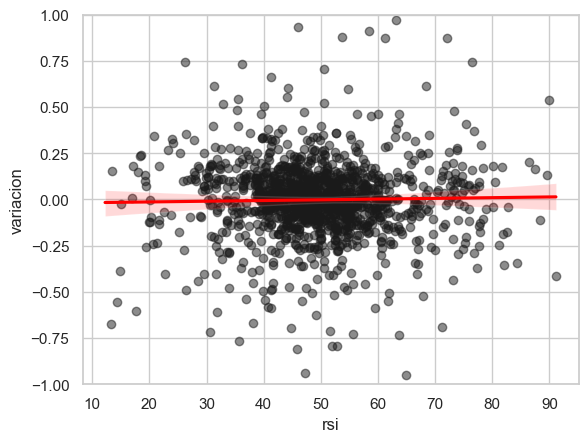

In [9]:
sns.set(style="whitegrid")
g = sns.regplot(
    x="rsi",
    y="variacion",
    data=df_1,
    line_kws={"color": "red"},
    scatter_kws={"color": "k", "alpha": 0.5},
)

g.set(ylim=(-1, 1))

In [10]:
df["variacion_tipo"] = np.where(df.variacion > 0, "Up", "Down")

medias = df.groupby("variacion_tipo").mean(numeric_only=True).loc[:, features].round(2)
desvios = df.groupby("variacion_tipo").std(numeric_only=True).loc[:, features].round(2)

print(f"Medias según clasificación \n{medias}\n")
print(f"Desvíos según clasificación \n{desvios}\n")

AttributeError: 'DataFrame' object has no attribute 'variacion'

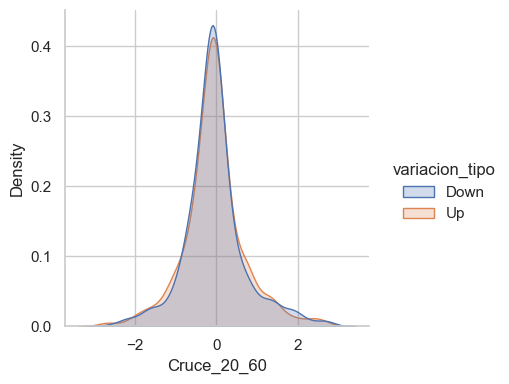

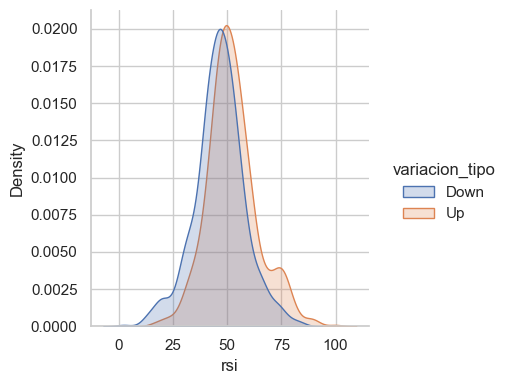

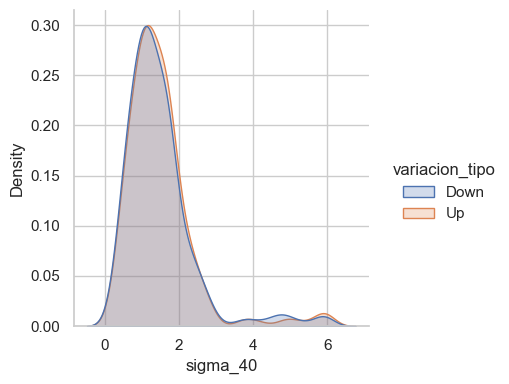

In [ ]:
for feature in features:
    sns.displot(df, x=feature, hue="variacion_tipo", kind="kde", height=4, fill=True)

# 3) Squeez Momentum Indicator

In [ ]:
df.set_index('time', inplace=True)
df

,open,close,high,low,volume
time,,,,,
2023-04-15 02:15:00,30388.5,30386.0,30400.0,30372.0,124.22
2023-04-15 02:30:00,30386.0,30386.2,30399.5,30344.5,183.56
2023-04-15 02:45:00,30386.2,30378.0,30406.5,30378.0,100.04
2023-04-15 03:00:00,30378.0,30389.0,30420.5,30375.5,166.78
2023-04-15 03:15:00,30389.0,30386.0,30405.0,30382.5,124.14
...,...,...,...,...,...
2023-04-29 14:45:00,29346.0,29331.5,29351.0,29321.0,158.80
2023-04-29 15:00:00,29331.5,29308.0,29332.0,29308.0,148.35
2023-04-29 15:15:00,29308.5,29330.0,29338.0,29308.0,135.06


In [11]:
def true_range(prices):
    # Create a new dataframe with the necessary columns
    tr = pd.DataFrame(index=prices.index, columns=['tr'])
    tr.iloc[0] = 0
    
    # Calculate the True Range for each day
    for i in range(1, len(prices)):
        tr.iloc[i] = max(prices['high'].iloc[i] - prices['low'].iloc[i], abs(prices['high'].iloc[i] - prices['close'].iloc[i-1]), abs(prices['low'].iloc[i] - prices['close'].iloc[i-1]))
    
    return tr

tr = true_range(df)
tr

,tr
0,0
1,55.0
2,28.5
3,45.0
4,22.5
...,...
1394,30.0
1395,24.0
1396,30.0
1397,18.5


In [ ]:
# Nota: Este código puede requerir algunas adaptaciones según la estructura de tus datos. 
#Asumimos que los datos están almacenados en un archivo CSV con una columna llamada 'date' como índice y las columnas 'close', 'high', 'low' y 'tr'.

import sys

sys.exit(0)
import ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inputs
length = 20
mult = 2.0
lengthKC = 20
multKC = 1.5
useTrueRange = True

# Load data (assuming 'close', 'high', 'low', and 'tr' columns are available)


# Calculate BB
basis = ta.trend.sma_indicator(df['close'], window=length, fillna=False)
# basis = ta.sma(df['close'], length=length)
# dev = multKC * ta.stdev(df['close'], length=length)
dev = multKC * df['close'].tail(length).std()
upperBB = basis + dev
lowerBB = basis - dev

# Calculate KC
ma = ta.trend.sma_indicator(df['close'], window=lengthKC)
tr = tr(df)
rangema = ta.trend.sma_indicator(tr['TR'], window=lengthKC)
upperKC = ma + rangema * multKC
lowerKC = ma - rangema * multKC

sqzOn = (lowerBB > lowerKC) & (upperBB < upperKC)
sqzOff = (lowerBB < lowerKC) & (upperBB > upperKC)
noSqz = (~sqzOn) & (~sqzOff)

# val = ta.linreg(df['close'] - ta.avg([ta.highest(df['high'], length=lengthKC), ta.lowest(df['low'], length=lengthKC), ta.sma(df['close'], length=lengthKC)]), length=lengthKC)
# Calcular la media móvil de cierre
sma = df['close'].rolling(window=lengthKC).mean()

# Calcular la banda de Keltner Channel
range_high = df['high'].rolling(window=lengthKC).max()
range_low = df['low'].rolling(window=lengthKC).min()
kc_band = (range_high + range_low + sma) / 3

# Calcular el indicador ajustado por la banda de Keltner Channel
adjusted_indicator = df['close'] - kc_band
# val = np.polyfit(range(len(adjusted_indicator.values)), adjusted_indicator.values, deg=1)[0]
# Convertir la serie de datos de Pandas a NumPy
adj_arr = np.array(adjusted_indicator)

# Calcular el valor de la pendiente de la regresión lineal
val = np.polyfit(tr(len(adj_arr)), adj_arr, deg=1)[0]




# val = ta.linreg(
#     df['close'] - ta.avg([ta.highest(df['high'], length=lengthKC), 
#     ta.lowest(df['low'], length=lengthKC),
#     ta.sma(df['close'], length=lengthKC)]), 
#     length=lengthKC
#     )

bcolor = np.where(val > 0, np.where(val > val.shift(1), 'lime', 'green'), np.where(val < val.shift(1), 'red', 'maroon'))
scolor = np.where(noSqz, 'blue', np.where(sqzOn, 'black', 'gray'))

plt.plot(val, color=bcolor, linestyle='-', linewidth=4)
plt.plot(np.zeros_like(val), color=scolor, marker='x', linestyle='-', linewidth=2)
plt.show()




TypeError: 'DataFrame' object is not callable

In [ ]:
# Nota: Este código puede requerir algunas adaptaciones según la estructura de tus datos. 
#Asumimos que los datos están almacenados en un archivo CSV con una columna llamada 'date' como índice y las columnas 'close', 'high', 'low' y 'tr'.
import sys

sys.exit(0)

import ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Inputs
length = 20
mult = 2.0
lengthKC = 20
multKC = 1.5
useTrueRange = True

# Calculate BB
basis = ta.trend.sma_indicator(df['close'], window=length, fillna=False)
dev = multKC * df['close'].tail(length).std()
upperBB = basis + dev
lowerBB = basis - dev

# Calculate KC
ma = ta.trend.sma_indicator(df['close'], window=lengthKC)
true_range = tr(df)
rangema = ta.trend.sma_indicator(true_range['TR'], window=lengthKC)
upperKC = ma + rangema * multKC
lowerKC = ma - rangema * multKC

sqzOn = (lowerBB > lowerKC) & (upperBB < upperKC)
sqzOff = (lowerBB < lowerKC) & (upperBB > upperKC)
noSqz = (~sqzOn) & (~sqzOff)

# val = ta.linreg(df['close'] - ta.avg([ta.highest(df['high'], length=lengthKC), ta.lowest(df['low'], length=lengthKC), ta.sma(df['close'], length=lengthKC)]), length=lengthKC)
# Calcular la media móvil de cierre
sma = df['close'].rolling(window=lengthKC).mean()

# Calcular la banda de Keltner Channel
range_high = df['high'].rolling(window=lengthKC).max()
range_low = df['low'].rolling(window=lengthKC).min()
kc_band = (range_high + range_low + sma) / 3

# Calcular el indicador ajustado por la banda de Keltner Channel
adjusted_indicator = df['close'] - kc_band
# val = np.polyfit(range(len(adjusted_indicator.values)), adjusted_indicator.values, deg=1)[0]
# Convertir la serie de datos de Pandas a NumPy
adj_arr = np.array(adjusted_indicator)

# Calcular el valor de la pendiente de la regresión lineal
val = np.polyfit(true_range(len(adj_arr)), adj_arr, deg=1)[0]




bcolor = np.where(val > 0, np.where(val > val.shift(1), 'lime', 'green'), np.where(val < val.shift(1), 'red', 'maroon'))
scolor = np.where(noSqz, 'blue', np.where(sqzOn, 'black', 'gray'))

plt.plot(val, color=bcolor, linestyle='-', linewidth=4)
plt.plot(np.zeros_like(val), color=scolor, marker='x', linestyle='-', linewidth=2)
plt.show()




TypeError: 'DataFrame' object is not callable

In [ ]:
import ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Inputs
length = 20
mult = 2.0
lengthKC = 20
multKC = 1.5
useTrueRange = True

# Calculate BB
basis = ta.trend.sma_indicator(df['close'], window=length, fillna=False)
dev = multKC * df['close'].tail(length).std()
upperBB = basis + dev
lowerBB = basis - dev

# Calculate KC
ma = ta.trend.sma_indicator(df['close'], window=lengthKC)
true_range = true_range(df)
rangema = ta.trend.sma_indicator(true_range['tr'], window=lengthKC)
upperKC = ma + rangema * multKC
lowerKC = ma - rangema * multKC

sqzOn = (lowerBB > lowerKC) & (upperBB < upperKC)
sqzOff = (lowerBB < lowerKC) & (upperBB > upperKC)
noSqz = (~sqzOn) & (~sqzOff)

# Calcular la media móvil de cierre
sma = df['close'].rolling(window=lengthKC).mean()

# Calcular la banda de Keltner Channel
range_high = df['high'].rolling(window=lengthKC).max()
range_low = df['low'].rolling(window=lengthKC).min()
kc_band = (range_high + range_low + sma) / 3

# Calcular el indicador ajustado por la banda de Keltner Channel
adjusted_indicator = df['close'] - kc_band

# Calcular el valor de la pendiente de la regresión lineal
x = adjusted_indicator.values[-lengthKC:]
y = df['close'].values[-lengthKC:]
# slope, _, _ , _, _ = linregress(x, y)
# val = slope
val = linregress(x, y)

bcolor = np.where(val > 0, np.where(val > val.shift(1), 'lime', 'green'), np.where(val < val.shift(1), 'red', 'maroon'))
scolor = np.where(noSqz, 'blue', np.where(sqzOn, 'black', 'gray'))

plt.plot(val, color=bcolor, linestyle='-', linewidth=4)
plt.plot(np.zeros_like(val), color=scolor, marker='x', linestyle='-', linewidth=2)
plt.show()


TypeError: '>' not supported between instances of 'LinregressResult' and 'int'

In [ ]:
df['tr'] = true_range(df)
df

,open,close,high,low,volume,time,tr
0,30388.5,30386.0,30400.0,30372.0,124.22,2023-04-15 02:15:00,0
1,30386.0,30386.2,30399.5,30344.5,183.56,2023-04-15 02:30:00,55.0
2,30386.2,30378.0,30406.5,30378.0,100.04,2023-04-15 02:45:00,28.5
3,30378.0,30389.0,30420.5,30375.5,166.78,2023-04-15 03:00:00,45.0
4,30389.0,30386.0,30405.0,30382.5,124.14,2023-04-15 03:15:00,22.5
...,...,...,...,...,...,...,...
1394,29346.0,29331.5,29351.0,29321.0,158.80,2023-04-29 14:45:00,30.0
1395,29331.5,29308.0,29332.0,29308.0,148.35,2023-04-29 15:00:00,24.0
1396,29308.5,29330.0,29338.0,29308.0,135.06,2023-04-29 15:15:00,30.0
1397,29330.0,29332.0,29333.0,29314.5,140.54,2023-04-29 15:30:00,18.5


In [12]:
# import required libraries

import numpy as np



# parameter setup
length = 20
mult = 2
length_KC = 20
mult_KC = 1.5

# calculate BB
m_avg = df['close'].rolling(window=length).mean()
m_std = df['close'].rolling(window=length).std(ddof=0)
df['upper_BB'] = m_avg + mult * m_std
df['lower_BB'] = m_avg - mult * m_std

# calculate true range
#TODO: solo me interesa la columna TR
#TODO: chequear que coincida con la funcion ya creada
df['tr0'] = abs(df["high"] - df["low"])
df['tr1'] = abs(df["high"] - df["close"].shift())
df['tr2'] = abs(df["low"] - df["close"].shift())
df['tr'] = df[['tr0', 'tr1', 'tr2']].max(axis=1)

# calculate KC
range_ma = df['tr'].rolling(window=length_KC).mean()
df['upper_KC'] = m_avg + range_ma * mult_KC
df['lower_KC'] = m_avg - range_ma * mult_KC

# calculate bar value
highest = df['high'].rolling(window = length_KC).max()
lowest = df['low'].rolling(window = length_KC).min()
m1 = (highest + lowest)/2
df['value'] = (df['close'] - (m1 + m_avg)/2)
fit_y = np.array(range(0,length_KC))
df['value'] = df['value'].rolling(window = length_KC).apply(lambda x: 
                        np.polyfit(fit_y, x, 1)[0] * (length_KC-1) + 
                        np.polyfit(fit_y, x, 1)[1], raw=True)

# check for 'squeeze'
df['squeeze_on'] = (df['lower_BB'] > df['lower_KC']) & (df['upper_BB'] < df['upper_KC'])
df['squeeze_off'] = (df['lower_BB'] < df['lower_KC']) & (df['upper_BB'] > df['upper_KC'])

# buying window for long position:
# 1. black cross becomes gray (the squeeze is released)
long_cond1 = (df.iloc[-2]['squeeze_off'] == False) & (df.iloc[-1]['squeeze_off'] == True) 
# 2. bar value is positive => the bar is light green k
long_cond2 = df['value'][-1] > 0
enter_long = long_cond1 and long_cond2

# buying window for short position:
# 1. black cross becomes gray (the squeeze is released)
short_cond1 = (df['squeeze_off'][-2] == False) & (df['squeeze_off'][-1] == True) 
# 2. bar value is negative => the bar is light red 
short_cond2 = df['value'][-1] < 0
enter_short = short_cond1 and short_cond2

KeyError: -2